### Finetune DINOv2 for semantic segmentation task

In [1]:
import torch
from torchvision.transforms import v2
from torch.hub import load
import pytorch_lightning as pl
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
from utils import overlay

import matplotlib.pyplot as plt
import warnings
import os
from pycocotools.coco import COCO

# warnings.filterwarnings("ignore")

from preprocess import coco_annotations_to_masks, resize_images_folder
from train import prepare_model, DataModule

Using fiftyone to look at data

In [2]:
# The directory containing the dataset to import
RAW_IMAGES = 'data/Step_B_C60/RawImages'
ANN_PATH = 'data/Step_B_C60/masking_coco 1.0/annotations/instances_default.json'


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


<Figure size 1200x1000 with 0 Axes>

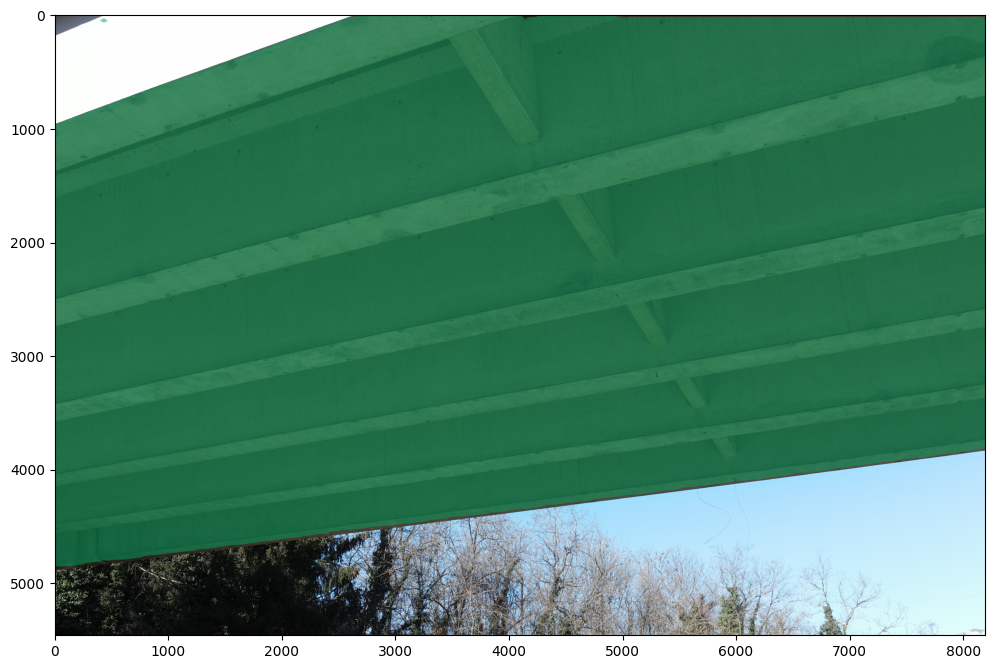

In [3]:
coco = COCO(ANN_PATH)
img_num = 44
img = coco.imgs[img_num]

plt.figure(figsize = (12,10))

image = np.array(Image.open(os.path.join(RAW_IMAGES, img['file_name'])))
plt.figure(figsize = (12,10))
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

In [4]:
# # A name for the dataset
# name = "briges"
# 
# dataset = fo.Dataset.from_dir(
#     labels_path= ANN_PATH,
#     dataset_type=fo.types.COCODetectionDataset,
#     data_path=RAW_IMAGES,
#     name=name)
# 
# session = fo.launch_app(dataset)

Create segmentation masks and resize images for convenience

In [5]:
prepare_images = False
DOWNSCALE_FACTOR = 7

if prepare_images:
    orig_masks_folder_path = coco_annotations_to_masks(ann_path=ANN_PATH, images_folder=RAW_IMAGES, ext='JPG')
    resized_images_folder_path = resize_images_folder(RAW_IMAGES, DOWNSCALE_FACTOR, ext='JPG', interpolation=cv2.INTER_AREA)
    resized_masks_folder_path = resize_images_folder(RAW_IMAGES + '_masks', DOWNSCALE_FACTOR, ext='png', interpolation=cv2.INTER_NEAREST)

Create train and validation datasets:

In [6]:
if not prepare_images:
    resized_images_folder_path = f'data/Step_B_C60/RawImages_{DOWNSCALE_FACTOR}x_downscaled'
    resized_masks_folder_path = f'data/Step_B_C60/RawImages_masks_{DOWNSCALE_FACTOR}x_downscaled'
    if not os.path.exists(resized_images_folder_path):
         os.makedirs(resized_images_folder_path)
    if not os.path.exists(resized_masks_folder_path):
         os.makedirs(resized_masks_folder_path)
        
    all_labeled_images_names = [img for img in os.listdir(resized_images_folder_path) if os.path.isfile(os.path.join(resized_masks_folder_path, img.split(".")[0] + ".png"))]


Here is how model can be trained:

In [7]:
BATCH_SIZE = 6
WORKERS = 2
LR = 1e-4
WD = 0.003
MAX_EPOCHS = 30
DINO_MODEL_NAME = 'dinov2_s'

segmentator = prepare_model(checkpoint_path=None,
                            lr=LR,
                            weight_decay=WD,
                            dino_model_name=DINO_MODEL_NAME)
# train_size here defines number of images in train dataset  
dm = DataModule(resized_images_folder_path,
                resized_masks_folder_path,
                train_size=120,
                batch_size=BATCH_SIZE,
                workers=WORKERS)
trainer = pl.Trainer(max_epochs=MAX_EPOCHS,
                     precision='16-mixed',  #Faster training on RTX GPUs
                     accelerator='cuda' if torch.cuda.is_available() else 'cpu',  
                     check_val_every_n_epoch=5)
                     #enable_progress_bar=False

trainer.fit(model=segmentator,
            datamodule=dm)

Using cache found in /home/teshbek/.cache/torch/hub/facebookresearch_dinov2_main


Dataset len: 149


100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


Dataset mean and std: tensor([98.0172, 96.3197, 90.6188]), tensor([58.6365, 62.6975, 67.6406])
Dataset len: 149
Train dataset len: 120
Val dataset len: 29



  | Name             | Type               | Params
--------------------------------------------------------
0 | net              | SegmentationNet    | 22.6 M
1 | loss             | BCEWithLogitsLoss  | 0     
2 | train_loss       | MeanMetric         | 0     
3 | val_loss         | MeanMetric         | 0     
4 | test_loss        | MeanMetric         | 0     
5 | jaccard_train    | BinaryJaccardIndex | 0     
6 | jaccard_val      | BinaryJaccardIndex | 0     
7 | jaccard_val_best | MaxMetric          | 0     
--------------------------------------------------------
581 K     Trainable params
22.1 M    Non-trainable params
22.6 M    Total params
90.560    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Here is the validation metric for this training run:

In [12]:
trainer.callback_metrics['val/jaccard_best'].item()

0.7956280708312988

### Eval model with trained weights

In [2]:
checkpoint_path = 'weights/dino_seg_head.ckpt'
segmentator = prepare_model(checkpoint_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentator = segmentator.eval().to(device)

Using cache found in /home/teshbek/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
# Path to testing image, images with nubmer larger than 121 is not labeled
all_dir_images = os.listdir(resized_images_folder_path)
image_path = os.path.join(resized_images_folder_path, all_dir_images[0])

img_transform = v2.Compose([
    v2.Resize((14*64,14*64)),
    v2.ToTensor(),
    #v2.Normalize(mean=[98.0114/255, 96.3234/255,  90.6137/255], std=[58.8723/255, 62.9214/255, 67.8434/255]),
])

image = Image.open(image_path).convert("RGB")
transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

sigm = torch.nn.Sigmoid()
predicted_mask = sigm(segmentator(transformed_image).cpu().detach()).numpy()
# Display the image and the mask
image = np.squeeze(transformed_image.cpu().detach()).numpy()
image = np.moveaxis(image, 0, -1)
plt.imshow(image)
plt.show()
pos = plt.imshow((np.squeeze(predicted_mask))) 
plt.colorbar(pos)
plt.show()
plt.imshow((np.squeeze(predicted_mask)>0.5)) 
plt.show()

NameError: name 'resized_images_folder_path' is not defined

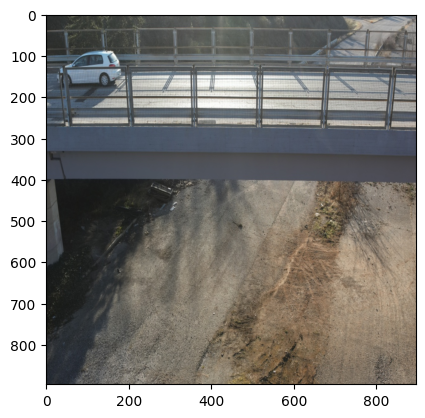

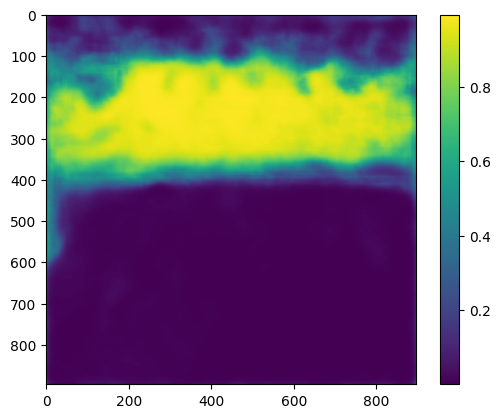

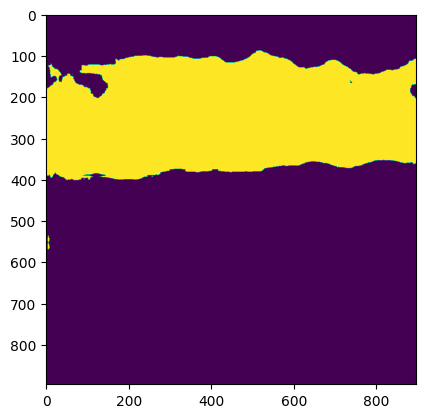

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


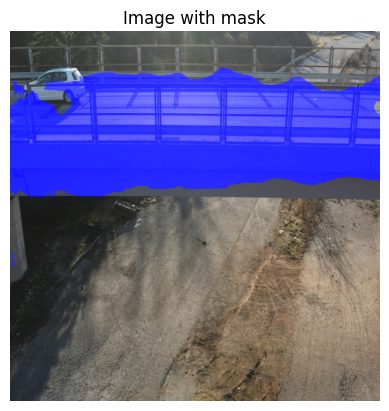

In [24]:
# Sample one random unannotated image
from random import sample 
import glob
from natsort import natsorted

image_paths = list(glob.glob(os.path.join(resized_images_folder_path, '*.JPG')))
image_paths = natsorted(image_paths, key=lambda y: y.lower())[149:]
image_path = sample(image_paths, 1)[0]

image = Image.open(image_path).convert("RGB")
transformed_image = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

sigm = torch.nn.Sigmoid()
predicted_mask = sigm(segmentator(transformed_image).cpu().detach()).numpy()


# Display the image and the mask
image = np.squeeze(transformed_image.cpu().detach()).numpy()
image = np.moveaxis(image, 0, -1)
predicted_mask = np.squeeze(predicted_mask)
predicted_mask = cv2.resize(predicted_mask, (image.shape[0], image.shape[1]))
plt.imshow(image)
plt.show()
# Mask from probabilities
pos = plt.imshow((np.squeeze(predicted_mask))) 
plt.colorbar(pos)
plt.show()
# Binary mask
plt.imshow((np.squeeze(predicted_mask)>0.5)) 
plt.show()
plt.imshow(overlay(image, np.squeeze(predicted_mask)>0.5, [255, 0, 0], 0.5, resize=None)) 
plt.axis('off') 
plt.title("Image with mask") 
plt.show()